In [0]:
# Set up
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets
import time
from torch.utils.data import DataLoader

In [0]:
# define model parameters
num_epochs = 90  # original paper
batch_size = 128
momentum = 0.9
lr_decay = 0.0005
lr_init = 0.01
img_dim = 227  # pixels
num_classes = 1000  # 1000 classes for imagenet 2012 dataset

In [0]:
class AlexNet(nn.Module):
    """
    Convolutional Neural Network model from AlexNet paper
    """
    def __init__(self):
        """
        Defining the layers for this network
        """
        super().__init__()
        
        # The input size is (N, 3, 227, 227), even though in the original paper
        # it states the input dimensions are 224x224. Not possible as the first
        # convolution doesn't lead to 55x55 with the size proposed in the paper.
        self.net = nn.Sequential(
            
            # Convolution Block
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), # [N x 96 x 55 x 55]
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # [N x 96 x 27 x 27]
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # [N x 256 x 27 x 27]
            nn.ReLU(),
            nn.LocalResponseNorm(5, 1e-4, 0.75, 2),
            nn.MaxPool2d(3, 2), # [N x 256 x 13 x 13]
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # [N x 384 x 13 x 13]
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # [N x 384 x 13 x 13]
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # [N x 256 x 13 x 13]
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # [N x 256 x 6 x 6]
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6)) # [N x 256*6*6]
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=9216, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1000),
        )
        self.parameters_init()
    
    def parameters_init(self):
        """
        Initializes the weights and biases according to AlexNet Paper, Section 5.
        """  
        # Biases in the second, fourth, and fifth convolutional layers, as well as 
        # the fully-connected hidden layers are initialized at 1. In the remaning
        # layers, the biases are initialized at 0.
        for i in range(len(self.net)):
          if isinstance(self.net[i], nn.Conv2d):
              nn.init.normal_(self.net[i].weight, mean=0, std=0.01)
              if i == 4 or i == 10 or i == 12:
                nn.init.constant_(self.net[i], 1)
              else:
                nn.init.constant_(self.net[i].bias, 0)

        for i in range(len(self.classifier)):
          if isinstance(self.classifier[i], nn.Linear):
              nn.init.normal_(self.classifier[i].weight, mean=0, std=0.01)
              nn.init.constant_(self.classifier[i].bias, 1)
    
    def forward(self, x):
        """
        Pass the input through the network to produce class scores

        Input=> x: Tensor that contains the input images. (N x 3 x H x W)
        Output=> scores: Tensor that contains the class scores. (N x num_classes)
        """
        conv = self.net(x)
        avg_pool = self.avgpool(conv)
        scores = self.classifier(avg_pool)
        return scores

In [0]:
from torch.utils.data import sampler

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': T.Compose([
          T.RandomResizedCrop(img_dim),
          T.RandomHorizontalFlip(),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': T.Compose([
          T.Resize(256),
          T.CenterCrop(img_dim),
          T.ToTensor(),
          T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

data_size = {
    'train': range(49000),
    'val': range(49000, 50000),
}

image_datasets = {x: datasets.CIFAR10('./cs231n/datasets', train=True, download=True,
                                      transform=data_transforms[x]) for x in ['train', 'val']
                  }
image_dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, 
                                   sampler=sampler.SubsetRandomSampler(data_size[x]), num_workers=8) for x in ['train', 'val']
                     }
class_names = image_datasets['train'].classes

device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


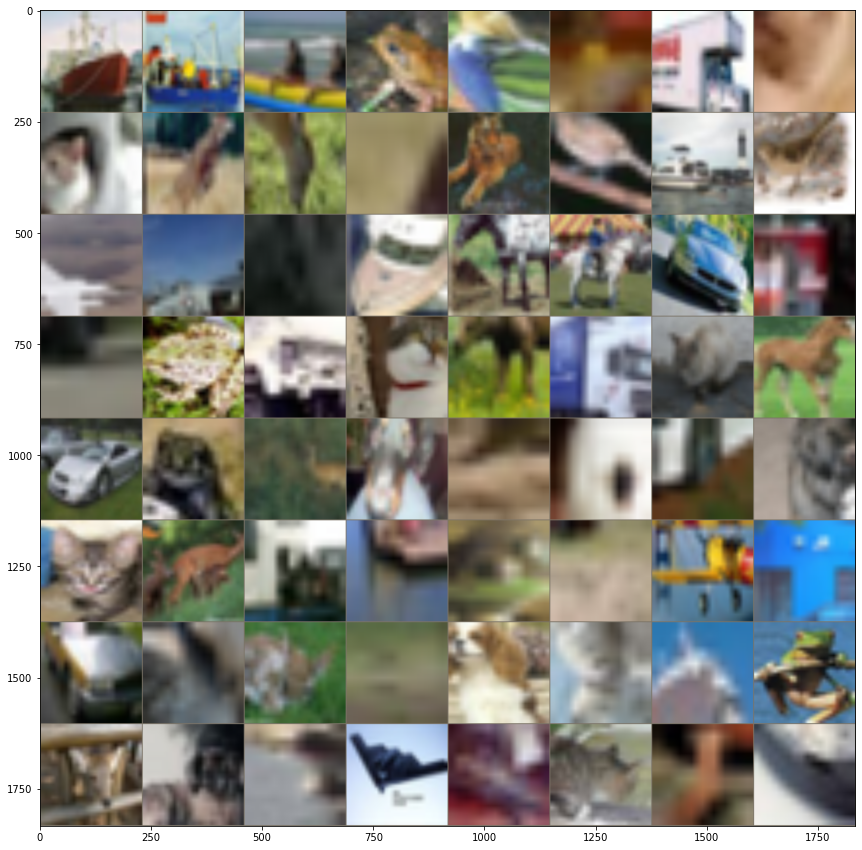

In [0]:
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)

# Get a batch of training data
inputs, classes = next(iter(image_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(15, 15))
imshow(out, ax=ax)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
  """
  Support function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  # Keep track of the best_model and the best validation accuracy
  best_model = copy.deepcopy(model.state_dict())
  best_val = -1

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()  # Set model to evaluation mode
      
      # Keeping track of the loss of one epoch and the number 
      # of correctly labeled images.
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for x, y in image_dataloaders[phase]:
        x, y = x.to(device), y.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        # Track history only in the training phase.
        with torch.set_grad_enabled(phase == 'train'):
          scores = model(x)
          loss = criterion(scores, y)
          _, preds = scores.max(1)

          # Backward pass -- Only in the training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss * x.size(0)
        running_corrects += (preds == y).sum()

      # If training, activate the learning rate scheduler
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / len(data_size[phase])
      epoch_acc = running_corrects.double() / len(data_size[phase])

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
      
      if phase == 'val' and epoch_acc > best_val:
        best_val = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    
      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_val))

  # Load the best model parameters
  model.load_state_dict(best_model)
  return model


In [0]:
def visualize_model(model, device, rows=3, cols=3):
  """
  Displays predictions for a few images
  """
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(image_dataloaders['val']):
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size(0)):
        imshow(imgs.data.cpu()[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds.cpu()[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [0]:
# Fine-Tuning All Network
alexnet_ft = torchvision.models.alexnet(pretrained=True, progress=True)
num_features = alexnet_ft.classifier[6].in_features

alexnet_ft.classifier[6] = nn.Linear(num_features, 10) # There are 10 classes in CIFAR10 dataset
criterion = nn.CrossEntropyLoss()

# Using GPU
alexnet_ft = alexnet_ft.to(device)

# A low learning rate is used for finetuning as the pretrained weights shouldn't
# be changed drastically. Also the whole network is being finetuned as all parameters 
# of the network are passed to the optimizer object.
optimizer_ft = optim.SGD(alexnet_ft.parameters(), lr=1e-3, momentum=0.9) 

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

new_model_ft = train_model(alexnet_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=10, device=device)

Epoch 0/9
----------
train Loss: 1.0941 Acc: 0.6115

val Loss: 0.5798 Acc: 0.7960

Epoch 1/9
----------
train Loss: 0.8882 Acc: 0.6861

val Loss: 0.4290 Acc: 0.8450

Epoch 2/9
----------
train Loss: 0.8163 Acc: 0.7114

val Loss: 0.3805 Acc: 0.8650

Epoch 3/9
----------
train Loss: 0.7782 Acc: 0.7252

val Loss: 0.3869 Acc: 0.8700

Epoch 4/9
----------
train Loss: 0.7488 Acc: 0.7359

val Loss: 0.3421 Acc: 0.8820

Epoch 5/9
----------
train Loss: 0.6697 Acc: 0.7638

val Loss: 0.2984 Acc: 0.8920

Epoch 6/9
----------
train Loss: 0.6492 Acc: 0.7720

val Loss: 0.2942 Acc: 0.8970

Epoch 7/9
----------
train Loss: 0.6464 Acc: 0.7736

val Loss: 0.2882 Acc: 0.8960

Epoch 8/9
----------
train Loss: 0.6404 Acc: 0.7751

val Loss: 0.2882 Acc: 0.9020

Epoch 9/9
----------
train Loss: 0.6308 Acc: 0.7768

val Loss: 0.2876 Acc: 0.8940

Training complete in 13m 17s
Best val Acc: 0.902000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


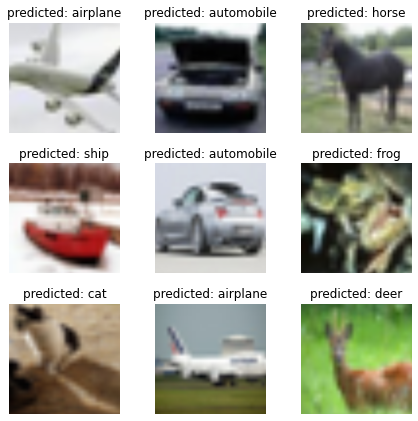

In [0]:
visualize_model(new_model_ft, device=device)
plt.tight_layout()

In [0]:
# Fine-Tuning Last Two Layers (may be applied to any layer)
alexnet_ft = torchvision.models.alexnet(pretrained=True, progress=True)

# Adding the last linear classifier layer for 10 classes
num_features = alexnet_ft.classifier[6].in_features
alexnet_ft.classifier[6] = nn.Linear(num_features, 10) 

# Freezing the parameters of all layers and unfreezing the ones we want to fine-tune.
# Unfreezing the newly added classifier and the previous two fc layers
for param in alexnet_ft.parameters():
    param.requires_grad = False

for child in alexnet_ft.classifier.children():
  if isinstance(child, nn.Linear):
    for param in child.parameters():
        param.requires_grad = True

# Same set-up as finetuning every weight
alexnet_ft = alexnet_ft.to(device)
optimizer_ft = optim.SGD(alexnet_ft.parameters(), lr=1e-3, momentum=0.9) 
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

new_model_ft = train_model(alexnet_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=10, device=device)

Epoch 0/9
----------
train Loss: 1.1993 Acc: 0.5678

val Loss: 0.7238 Acc: 0.7450

Epoch 1/9
----------
train Loss: 1.0588 Acc: 0.6219

val Loss: 0.6228 Acc: 0.7860

Epoch 2/9
----------
train Loss: 1.0136 Acc: 0.6389

val Loss: 0.5845 Acc: 0.7910

Epoch 3/9
----------
train Loss: 0.9981 Acc: 0.6475

val Loss: 0.5757 Acc: 0.7990

Epoch 4/9
----------
train Loss: 0.9758 Acc: 0.6528

val Loss: 0.5594 Acc: 0.7940

Epoch 5/9
----------
train Loss: 0.9430 Acc: 0.6628

val Loss: 0.5449 Acc: 0.8030

Epoch 6/9
----------
train Loss: 0.9417 Acc: 0.6652

val Loss: 0.5416 Acc: 0.8090

Epoch 7/9
----------
train Loss: 0.9341 Acc: 0.6653

val Loss: 0.5420 Acc: 0.8050

Epoch 8/9
----------
train Loss: 0.9294 Acc: 0.6696

val Loss: 0.5341 Acc: 0.8080

Epoch 9/9
----------
train Loss: 0.9336 Acc: 0.6677

val Loss: 0.5327 Acc: 0.8160

Training complete in 12m 33s
Best val Acc: 0.816000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


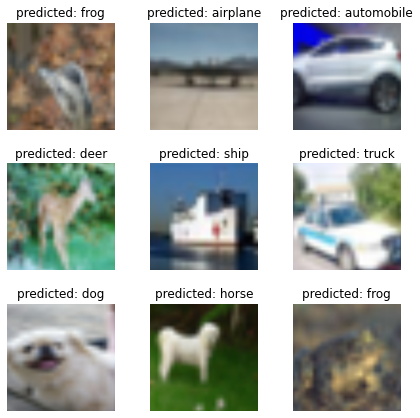

In [0]:
visualize_model(new_model_ft, device=device)
plt.tight_layout()

In [0]:
# Feature Extractor (CNN Codes)
alexnet_ft = torchvision.models.alexnet(pretrained=True, progress=True)
num_features = alexnet_ft.classifier[6].in_features
alexnet_ft.classifier[6] = nn.Linear(num_features, 10) # There are 10 classes in CIFAR10 dataset

# Using GPU
alexnet_ft = alexnet_ft.to(device)

# Freezing the parameters of all layers to get CNN codes of 4096-D vectors
# And Unfreezing the weight of the newly added classifier.
for param in alexnet_ft.parameters():
    param.requires_grad = False

alexnet_ft.classifier[6].weight.requires_grad = True
alexnet_ft.classifier[6].bias.requires_grad = True

# Same set-up as finetuning section except for the learning rate
# Learning rate can be set to yet again 0.01 because we are training
# only the last linear classifier. 
alexnet_ft = alexnet_ft.to(device)
optimizer_ft = optim.SGD(alexnet_ft.parameters(), lr=1e-2, momentum=0.9) 
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

new_model_ft = train_model(alexnet_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=10, device=device)

Epoch 0/9
----------
train Loss: 1.1964 Acc: 0.5733

val Loss: 0.7734 Acc: 0.7200

Epoch 1/9
----------
train Loss: 1.1030 Acc: 0.6062

val Loss: 0.6511 Acc: 0.7760

Epoch 2/9
----------
train Loss: 1.0610 Acc: 0.6219

val Loss: 0.5887 Acc: 0.7970

Epoch 3/9
----------
train Loss: 1.0415 Acc: 0.6287

val Loss: 0.5796 Acc: 0.8030

Epoch 4/9
----------
train Loss: 1.0170 Acc: 0.6365

val Loss: 0.5905 Acc: 0.8050

Epoch 5/9
----------
train Loss: 0.9327 Acc: 0.6684

val Loss: 0.4809 Acc: 0.8270

Epoch 6/9
----------
train Loss: 0.9083 Acc: 0.6807

val Loss: 0.4697 Acc: 0.8380

Epoch 7/9
----------
train Loss: 0.8887 Acc: 0.6835

val Loss: 0.4670 Acc: 0.8340

Epoch 8/9
----------
train Loss: 0.8756 Acc: 0.6879

val Loss: 0.4596 Acc: 0.8380

Epoch 9/9
----------
train Loss: 0.8670 Acc: 0.6935

val Loss: 0.4643 Acc: 0.8300

Training complete in 12m 32s
Best val Acc: 0.838000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


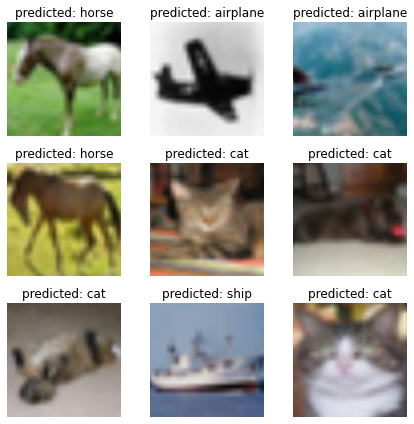

In [0]:
visualize_model(new_model_ft, device=device)
plt.tight_layout()